In [7]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Dueling Deep Q Networks do not require val computation of all state-action pairs
#Seperate val state, val action to cover state-space generally 
#Improves computation in scenario where ideal action is nothing, saves time over computing ALL state-action pairs
class DuelingDeepQNetwork(keras.Model):
    def __init__(self, n_actions, fc1_dims, fc2_dims):
        super(DuelingDeepQNetwork, self).__init__()
        self.dense1 = keras.layers.Dense(fc1_dims, activation='relu')
        self.dense2 = keras.layers.Dense(fc2_dims, activation='relu')
        self.Value = keras.layers.Dense(1, activation=None) #output raw val state
        self.Advantage = keras.layers.Dense(n_actions, activation=None) #importance of taking action
        
    #advantage & value streams are combined to form Q(s, a) estimate
    #cannot simply sum both, require addl op to compute & derive advantage & val from Q(s, a)
    #Q(s, a) still computed, ideally can apply normal/prioritized exp replay, other Q-learning algos
    def call(self, state):
        #feed-fwd through dense layers, then val, adv streams
        x = self.dense1(state)
        x = self.dense2(x)
        Value = self.Value(x)
        Advantage = self.Advantage(x)
        
        Q = (Value + (Advantage - tf.math.reduce_mean(Advantage, axis=1, keepdims=True)))
        return Q
    
    def advantage(self, state):
        x = self.dense1(state)
        x = self.dense2(x)
        Advantage = self.Advantage(x)
        
        return Advantage

In [3]:
class ReplayBuffer():
    def __init__(self, max_size, input_shape):
        self.mem_size = max_size
        self.mem_cntr = 0

        self.state_memory = np.zeros((self.mem_size, *input_shape),
                                        dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_shape),
                                        dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = done

        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, batch_size, replace=False)

        states = self.state_memory[batch]
        new_states = self.new_state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        dones = self.terminal_memory[batch]

        return states, actions, rewards, new_states, dones

In [4]:
class Agent():
    #replace defines when target net params updated (copied from online net) to provide model stability 
    def __init__(self, learning_rate, gamma, n_actions, epsilon, batch_size, input_dims, 
                epsilon_dec=1e-3, eps_end=0.01, 
                mem_size=1000000, fname='dueling_dqn.h5', fc1_dims=128,
                fc2_dims=128, replace=100):
        self.action_space = [i for i in range(n_actions)]
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_dec = epsilon_dec
        self.eps_min = eps_end
        self.fname = fname
        self.replace = replace
        self.batch_size = batch_size 
        
        self.learn_step_counter = 0
        self.memory = ReplayBuffer(mem_size, input_dims)
        self.q_eval = DuelingDeepQNetwork(n_actions, fc1_dims, fc2_dims) #online net 
        self.q_next = DuelingDeepQNetwork(n_actions, fc1_dims, fc2_dims) #target net  
        
        self.q_eval.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
        self.q_next.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
        
    def store_transition(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)
        
    def choose_action(self, observation):
        if np.random.random() < self.epsilon:
            action = np.random.choice(self.action_space)
        else:
            state = np.array([observation]) #add dim
            actions = self.q_eval.advantage(state) #determine importance of all actions 
            action = tf.math.argmax(actions, axis=1).numpy()[0] #provide index greatest action, returns single-elem arr, deref & access val
        
        return action

    #init mem filled w/ zeros, can either populate w/ random state-transitions OR 
    #if empty return
    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return
        
        #check if replace steps exec, if so update target network
        if self.learn_step_counter % self.replace == 0:
            self.q_next.set_weights(self.q_eval.get_weights())
        
        #sample mem transition from buffer, each contained in array dep on batch_size
        states, actions, rewards, states_, dones = self.memory.sample_buffer(self.batch_size)
        
        #q_pred 2D arr, each index contains list of action-vals per sampled state 
        q_pred = self.q_eval(states) #array of online net state-val by feed-fwd
        
        #determine max action value from future states via target net feed-fwd, keep array of size 1
        #argmax returns index of highest elem, reduce_max returns val highest elem
        q_next = tf.math.reduce_max(self.q_next(states_), axis=1, keepdims=True).numpy()
        q_target = np.copy(q_pred)
        
        #enumerate adds counter to iterator & returns it if needed
        #iterate through done-flags per each state of sampled batch, if true, set future q-val to zero to ensure termination
        #if in term state, no future rewards thus zero-val
        for idx, terminal in enumerate(dones):
            if terminal:
                q_next[idx] = 0.0
                
            #visit sampled state and for action taken in it, update state-val
            q_target[idx, actions[idx]] = rewards[idx] + self.gamma*q_next[idx]
        
        self.q_eval.train_on_batch(states, q_target) #attempt loss minimization via sampled states & target net
        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min else self.eps_min #reduce epsilon
        self.learn_step_counter += 1 #track learning iteration for updating target net 
    
    def save_model(self):
        self.q_eval.save(self.model_file)

    def load_model(self):
        self.q_eval = load_model(self.model_file)
        

In [5]:
def plotLearning(x, scores, epsilons, filename, lines=None):
    fig=plt.figure()
    ax=fig.add_subplot(111, label="1")
    ax2=fig.add_subplot(111, label="2", frame_on=False)

    ax.plot(x, epsilons, color="C0")
    ax.set_xlabel("Game", color="C0")
    ax.set_ylabel("Epsilon", color="C0")
    ax.tick_params(axis='x', colors="C0")
    ax.tick_params(axis='y', colors="C0")

    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
	    running_avg[t] = np.mean(scores[max(0, t-20):(t+1)])

    ax2.scatter(x, running_avg, color="C1")
    #ax2.xaxis.tick_top()
    ax2.axes.get_xaxis().set_visible(False)
    ax2.yaxis.tick_right()
    #ax2.set_xlabel('x label 2', color="C1")
    ax2.set_ylabel('Score', color="C1")
    #ax2.xaxis.set_label_position('top')
    ax2.yaxis.set_label_position('right')
    #ax2.tick_params(axis='x', colors="C1")
    ax2.tick_params(axis='y', colors="C1")

    if lines is not None:
        for line in lines:
            plt.axvline(x=line)

    plt.savefig(filename)

episode  0 score -339.0 average score -339.0 epsilon 0.97
episode  1 score -156.7 average score -247.9 epsilon 0.89
episode  2 score -435.3 average score -310.3 epsilon 0.80
episode  3 score -83.3 average score -253.6 epsilon 0.74
episode  4 score -291.9 average score -261.2 epsilon 0.63
episode  5 score -122.2 average score -238.1 epsilon 0.51
episode  6 score -109.6 average score -219.7 epsilon 0.01
episode  7 score -288.8 average score -228.4 epsilon 0.01
episode  8 score -149.6 average score -219.6 epsilon 0.01
episode  9 score -98.3 average score -207.5 epsilon 0.01
episode  10 score -344.0 average score -219.9 epsilon 0.01
episode  11 score -5.3 average score -202.0 epsilon 0.01
episode  12 score -155.5 average score -198.4 epsilon 0.01
episode  13 score -16.4 average score -185.4 epsilon 0.01
episode  14 score -182.5 average score -185.2 epsilon 0.01
episode  15 score -56.9 average score -177.2 epsilon 0.01
episode  16 score 4.0 average score -166.6 epsilon 0.01
episode  17 scor

episode  143 score 186.7 average score 133.7 epsilon 0.01
episode  144 score 234.3 average score 138.2 epsilon 0.01
episode  145 score 251.1 average score 143.4 epsilon 0.01
episode  146 score 258.4 average score 147.8 epsilon 0.01
episode  147 score 238.8 average score 150.0 epsilon 0.01
episode  148 score 291.4 average score 151.2 epsilon 0.01
episode  149 score 245.2 average score 151.7 epsilon 0.01
episode  150 score 215.0 average score 155.7 epsilon 0.01
episode  151 score 286.4 average score 161.1 epsilon 0.01
episode  152 score 289.1 average score 165.8 epsilon 0.01
episode  153 score 275.0 average score 172.2 epsilon 0.01
episode  154 score 230.8 average score 174.3 epsilon 0.01
episode  155 score 282.3 average score 177.5 epsilon 0.01
episode  156 score 243.2 average score 182.0 epsilon 0.01
episode  157 score 288.6 average score 185.0 epsilon 0.01
episode  158 score 269.9 average score 189.6 epsilon 0.01
episode  159 score 234.2 average score 189.5 epsilon 0.01
episode  160 s

episode  285 score 249.1 average score 236.8 epsilon 0.01
episode  286 score 280.0 average score 237.1 epsilon 0.01
episode  287 score 247.5 average score 237.1 epsilon 0.01
episode  288 score 217.0 average score 236.9 epsilon 0.01
episode  289 score 167.6 average score 236.3 epsilon 0.01
episode  290 score 291.3 average score 236.8 epsilon 0.01
episode  291 score 260.4 average score 236.7 epsilon 0.01
episode  292 score 249.0 average score 237.0 epsilon 0.01
episode  293 score 232.6 average score 236.9 epsilon 0.01
episode  294 score 248.2 average score 236.5 epsilon 0.01
episode  295 score 240.3 average score 236.3 epsilon 0.01
episode  296 score 280.6 average score 236.3 epsilon 0.01
episode  297 score 272.7 average score 236.9 epsilon 0.01
episode  298 score 248.4 average score 239.1 epsilon 0.01
episode  299 score 259.7 average score 239.5 epsilon 0.01
episode  300 score 190.5 average score 238.7 epsilon 0.01
episode  301 score 242.9 average score 238.6 epsilon 0.01
episode  302 s

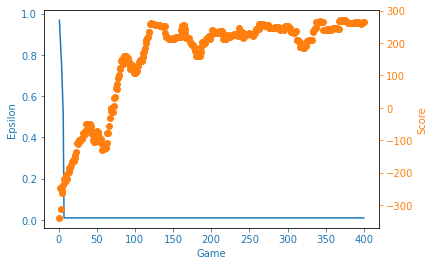

In [8]:
import gym
from gym import wrappers
if __name__ == '__main__':
    env = gym.make('LunarLander-v2')
    n_games = 400
    agent = Agent(gamma=0.99, epsilon=1, learning_rate=1e-3, input_dims=[8], 
                  epsilon_dec=1e-3, mem_size=100000, batch_size=64, eps_end=0.01,
                  fc1_dims=128, fc2_dims=128, replace=100, n_actions=4)

    scores, eps_history = [], []
    env = wrappers.Monitor(env, 'tmp/lunar-lander', video_callable=lambda episode_id: True, force=True)


    for i in range(n_games):
        done = False
        score = 0
        observation = env.reset()
        while not done:
            action = agent.choose_action(observation)
            observation_, reward, done, info = env.step(action)
            score += reward
            agent.store_transition(observation, action, reward, observation_, done)
            observation = observation_
            agent.learn()
        eps_history.append(agent.epsilon)
        scores.append(score)

        avg_score = np.mean(scores[-100:])
        print('episode ', i, 'score %.1f' % score,
                'average score %.1f' % avg_score,
                'epsilon %.2f' % agent.epsilon)

    filename='keras_lunar_lander.png'
    x = [i+1 for i in range(n_games)]
    plotLearning(x, scores, eps_history, filename)